In [1]:
import os
# ggf muss Pfad angepasst werden
os.chdir("{}/..".format(os.getcwd()))
os.getcwd()

'C:\\Users\\theur\\Documents\\Uni\\Master\\dmc19'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection, linear_model, metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from scipy.stats import uniform, randint
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split, cross_validate
#from scripts.utils import own_scorer, calc_scores

## Utils

In [3]:
# Calculate multiple scores
def calc_scores(y_test, y_pred):
    accuracy = metrics.accuracy_score(y_test, y_pred)
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    f2_score = (0 if all(y_pred == 0) else metrics.fbeta_score(y_test, y_pred, beta=2))
    dmc_score = np.sum(confusion_matrix * np.array([[0, -25], [-5, 5]]))

    return accuracy, f2_score, dmc_score/len(y_test), confusion_matrix

# Normalized DMC Score for usage as scorer
def own_scorer_normalized(estimator, X_val, ground_truth):
    prediction = estimator.predict(X_val)
    confusion_matrix = metrics.confusion_matrix(ground_truth, prediction)
    dmc_score = np.sum(confusion_matrix * np.array([[0, -25], [-5, 5]]))
    return dmc_score/len(ground_truth)

# DMC Score for usage as scorer
def own_scorer(estimator, X_val, ground_truth):
    prediction = estimator.predict(X_val)
    confusion_matrix = metrics.confusion_matrix(ground_truth, prediction)
    dmc_score = np.sum(confusion_matrix * np.array([[0, -25], [-5, 5]]))
    return dmc_score
# F2 Score for usage as scorer
def own_f2_score(estimator, X_val, ground_truth):
    prediction = estimator.predict(X_val)
    return 0 if all(prediction == 0) else metrics.fbeta_score(ground_truth, prediction, beta=2)


def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                results['mean_test_score'][candidate],
                results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


## Loading train data and add feature

In [4]:
df_train = pd.read_csv("data/extended_train.csv", sep="|")
df_y = df_train.fraud
df_X = df_train.drop(['fraud'], axis=1)

train_x, val_x, train_y, val_y = train_test_split(df_X, df_y, test_size=0.2)

print("Shape of train data: ", train_x.shape, "Shape of val data: ", val_x.shape)

Shape of train data:  (1503, 10) Shape of val data:  (376, 10)


## Creating a quantile scaled dataset

In [5]:
df_quant_scaled_y = df_train.fraud
df_wo_frauds = df_train.drop(['fraud'], axis=1)
heads = list(df_wo_frauds.columns.values)

qt = QuantileTransformer(n_quantiles=10, random_state=0)
df_quant_scaled_x = pd.DataFrame(qt.fit_transform(df_wo_frauds), columns=heads)
#df_quant_scaled['fraud'] = df_s_y
train_qs_x, val_qs_x, train_qs_y, val_qs_y = train_test_split(df_quant_scaled_x, df_quant_scaled_y, test_size=0.2)

print("Shape of train data: ", train_qs_x.shape, "Shape of val data: ", val_qs_x.shape)
train_qs_x.head()

Shape of train data:  (1503, 10) Shape of val data:  (376, 10)


,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,totalScannedLineItems
1550,9.999999e-01,0.648859,0.640472,0.722222,0.222222,1.000000e-07,0.667904,0.483474,0.389940,1.000000
466,2.777778e-01,0.951567,0.737107,0.111111,0.111111,9.999999e-01,0.490378,0.387489,0.079365,0.925926
273,1.000000e-07,0.286281,0.228311,1.000000,0.222222,2.222222e-01,0.745408,0.394678,0.704134,0.592593
550,1.000000e-07,0.074635,0.622208,0.666667,0.611111,7.777778e-01,0.624107,0.889571,0.898635,0.074074
673,2.777778e-01,0.082492,0.484902,0.444444,0.111111,1.000000e-07,0.588309,0.889163,0.890838,0.074074


## Support Vector Classifier 

In [6]:
lin_svc = SVC(kernel="linear", C=50)
res_train1 = cross_validate(lin_svc, train_x,train_y, scoring=own_scorer, cv=5,n_jobs=-1)['test_score']
res_train2 = cross_validate(lin_svc, train_qs_x,train_qs_y, scoring=own_scorer, cv=5,n_jobs=-1)['test_score']
res_n_train1 = cross_validate(lin_svc, train_x,train_y, scoring=own_scorer_normalized, cv=5,n_jobs=-1)['test_score']
res_n_train2 = cross_validate(lin_svc, train_qs_x,train_qs_y, scoring=own_scorer_normalized, cv=5,n_jobs=-1)['test_score']
print("Original Data: ", res_train1,"Scaled Data: ", res_train2)
print("Original Data: ", res_n_train1,"Scaled Data: ", res_n_train2)


Original Data:  [ 70  10  70  45 -50] Scaled Data:  [30 75 65 50 15]
Original Data:  [ 0.23255814  0.03322259  0.23255814  0.14950166 -0.16722408] Scaled Data:  [0.09933775 0.24916944 0.21666667 0.16666667 0.05      ]


In [12]:
param_grid = {
    "kernel" : ['linear', 'rbf','poly'],
    "C" : np.arange(1,500,10),
    "gamma" : np.arange(1,100),   #lgorithm" : [‘SAMME’, ‘SAMME.R’]
    "degree" : np.arange(1,10),
    "shrinking" : [True,False]
}
svc = SVC()
grid_search_svc = GridSearchCV(svc, param_grid = param_grid, scoring = own_scorer, n_jobs=-1,verbose=1,cv=5,refit = True)


In [13]:
grid_search_svc.fit(train_x, train_y)

Fitting 5 folds for each of 19800 candidates, totalling 99000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


KeyboardInterrupt: 

## XGBoost Classifier

In [13]:
default_xgb = xgb.XGBClassifier(n_jobs=6, verbosity=2)
res_train1 = cross_validate(default_xgb, train_x,train_y, scoring=own_scorer, cv=5,n_jobs=-1)['test_score']
res_train2 = cross_validate(default_xgb, train_qs_x,train_qs_y, scoring=own_scorer, cv=5,n_jobs=-1)['test_score']
res_n_train1 = cross_validate(default_xgb, train_x,train_y, scoring=own_scorer_normalized, cv=5,n_jobs=-1)['test_score']
res_n_train2 = cross_validate(default_xgb, train_qs_x,train_qs_y, scoring=own_scorer_normalized, cv=5,n_jobs=-1)['test_score']
print("Original Data: ", res_train1,"Scaled Data: ", res_train2)
print("Original Data: ", res_n_train1,"Scaled Data: ", res_n_train2)

Original Data:  [40 65 50 40 30] Scaled Data:  [35  0 55 15 25]
Original Data:  [0.13289037 0.21594684 0.16611296 0.13289037 0.10033445] Scaled Data:  [0.11627907 0.         0.18272425 0.05       0.08333333]


In [31]:
xgbc = xgb.XGBClassifier(gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=452,objective='binary:logistic')

In [36]:
res_train1 = cross_validate(xgbc, train_x,train_y, scoring=own_scorer, cv=5,n_jobs=-1)['test_score']
res_train2 = cross_validate(xgbc, train_qs_x,train_qs_y, scoring=own_scorer, cv=5,n_jobs=-1)['test_score']
print("Original Data: ", res_train1,"Scaled Data: ", res_train2)


Original Data:  [ 60  60 -15  30  20] Scaled Data:  [20 30 55 40 45]


## Gridsearch does not work very well with XGBboost. We need an alternative

In [ ]:
xgboost = xgb.XGBClassifier(tree_method='gpu_hist')

params = {
    "learning_rate": np.linspace(1, 1e-3, 20),
    "gamma": np.linspace(1e-1, 100, 100), #"booster": ["gbtree", "gblinear", "dart"],
    "max_depth": np.linspace(1, 10,10,dtype=int),  # default 3
    "n_estimators": np.linspace(50, 750,300,dtype=int),  # default 100
    "colsample_bytree" : np.linspace(0.1, 1,10)
}
grid_search_xgb = GridSearchCV(xgboost, param_grid = params, scoring = own_scorer, n_jobs=-1,verbose=1,cv=5)
grid_search_xgb.fit(train_x,  train_y)

In [16]:
#Load Data to DMatrix
d_train = xgb.DMatrix(train_x, label=train_y)
param = {'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
#param['n_jobs'] = 4
param['eval_metric'] = 'auc'
bst = xgb.train(param, d_train, 50)

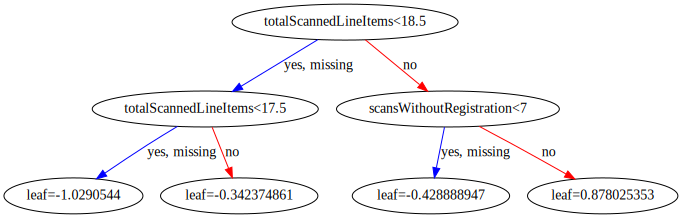

In [30]:
xgb.to_graphviz(bst, num_trees=3)

In [15]:
xgbc = XGBClassifier(gamma=0.1, learning_rate=0.1, max_depth=3, n_estimators=452,objective='binary:logistic')

NameError: name 'grid_search_xgb' is not defined